# Parallelize image filters with dask
This notebook will show how to parallize CPU-intensive workload using dask array. A simple uniform filter (equivalent to a mean filter) from `scipy.ndimage` is used for illustration purposes.

In [1]:
%pylab inline
from scipy.ndimage import uniform_filter
import dask.array as da

def mean(img):
    "ndimage.uniform_filter with `size=51`"
    return uniform_filter(img, size=51)

Populating the interactive namespace from numpy and matplotlib


## Get the image

'45.0 Mega pixels, shape (5122, 8810), dtype uint8'

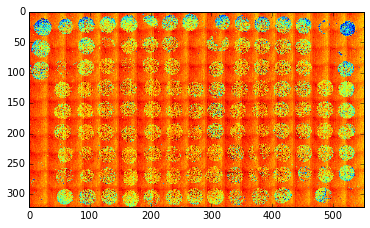

In [2]:
!if [ ! -e stitched--U00--V00--C00--Z00.png ]; then wget -q https://github.com/arve0/master/raw/master/stitched--U00--V00--C00--Z00.png; fi
img = imread('stitched--U00--V00--C00--Z00.png')
img = (img*255).astype(np.uint8) # image read as float32, image is 8 bit grayscale
imshow(img[::16, ::16])
mp = str(img.shape[0] * img.shape[1] * 1e-6 // 1)
'%s Mega pixels, shape %s, dtype %s' % (mp, img.shape, img.dtype)

## Initial speed
Lets try the filter directly on the image.

CPU times: user 2.52 s, sys: 64.2 ms, total: 2.59 s
Wall time: 2.7 s


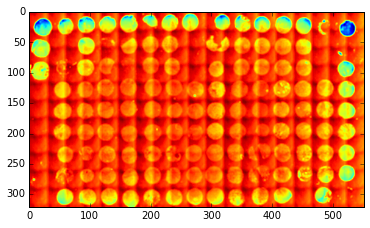

In [3]:
# filter directly
%time mean_nd = mean(img)
imshow(mean_nd[::16, ::16]);

## With dask
First, we'll create the dask array with one chunk only (`chunks=img.shape`).

In [4]:
img_da = da.from_array(img, chunks=img.shape)

`depth` defines the overlap. We have one chunk only, so overlap is not necessary.

`compute` must be called to start the computation.

CPU times: user 2.43 s, sys: 59 ms, total: 2.49 s
Wall time: 2.53 s


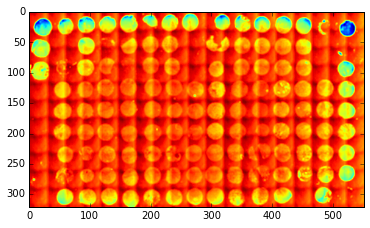

In [5]:
%time mean_da = img_da.map_overlap(mean, depth=0).compute()
imshow(mean_da[::16, ::16]);

As we can see, the performance is the same as applying the filter directly.

Now, lets chop up the image in chunks so that we can leverage all the cores in our computer.

In [6]:
from multiprocessing import cpu_count
cpu_count()

4

We have four cores, so lets split the array in four chunks.

In [7]:
img.shape, mean_da.shape, mean_nd.shape

((5122, 8810), (5122, 8810), (5122, 8810))

Pixels in both axes are even, so we can split the array in equally sized chunks. If we had odd shapes, chunks would not be the same size (given four cpu cores). E.g. 101x101 image => 50x50 and 51x51 chunks.

In [8]:
chunk_size = [x//2 for x in img.shape]
img_da = da.rechunk(img_da, chunks=chunk_size)

Now, lets see if the filtering is faster.

CPU times: user 3.09 s, sys: 165 ms, total: 3.26 s
Wall time: 1.23 s


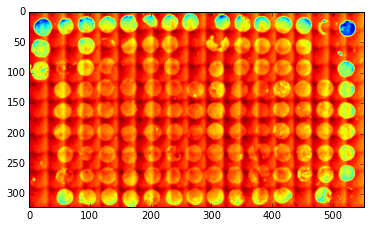

In [9]:
%time mean_da = img_da.map_overlap(mean, depth=0).compute()
imshow(mean_da[::16, ::16]);

It is :-)

If one opens the process manager, one will see that the python process is eating more then 100% CPU.

As we are looking at neighbor pixels to compute the mean intensity for the center pixel, you might wonder what happens in the seams between chunks? Lets examine that.

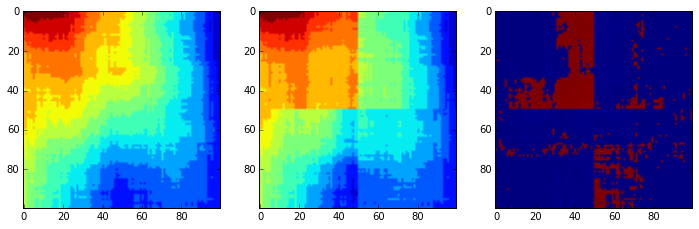

In [10]:
size = 50
mask = np.index_exp[chunk_size[0]-size:chunk_size[0]+size, chunk_size[1]-size:chunk_size[1]+size]

figure(figsize=(12,4))
subplot(131)
imshow(mean_nd[mask]) # filtered directly
subplot(132)
imshow(mean_da[mask]) # filtered in chunks with dask
subplot(133)
imshow(mean_nd[mask] - mean_da[mask]); # difference

To overcome this edge effect in the seams, we need to define a higher `depth` so that dask does the computation with an overlap. We need an overlap of 25 pixels (half the size of the neighborhood in `mean`).

CPU times: user 3.47 s, sys: 206 ms, total: 3.67 s
Wall time: 1.23 s


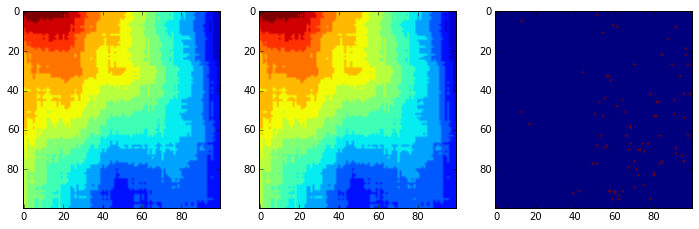

In [11]:
%time mean_da = img_da.map_overlap(mean, depth=25).compute()

figure(figsize=(12,4))
subplot(131)
imshow(mean_nd[mask]) # filtered directly
subplot(132)
imshow(mean_da[mask]) # filtered in chunks with dask
subplot(133)
imshow(mean_nd[mask] - mean_da[mask]); # difference

Edge effect is gone, nice! The dots in the difference is due to uniform_filter's limited precision. From the [manual](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.uniform_filter.html):

> The multi-dimensional filter is implemented as a sequence of one-dimensional uniform filters. The intermediate arrays are stored in the same data type as the output. Therefore, for output types with a limited precision, the results may be imprecise because intermediate results may be stored with insufficient precision.

Lets see if we can improve the performance. As we do not get 4x speedup, there might be that computation is not only CPU-bound. Chunksize of 1000 is a good place to start.

CPU times: user 2.39 s, sys: 183 ms, total: 2.57 s
Wall time: 1.24 s


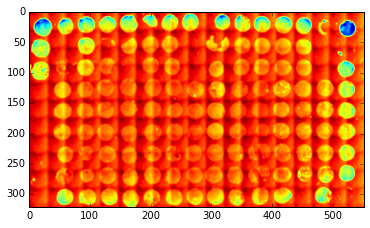

In [12]:
img_da = da.rechunk(img_da, 1000)
%time mean_da = img_da.map_overlap(mean, depth=25).compute()
imshow(mean_da[::16, ::16]);

As you see, adjusting the chunk size did not affect the performance significant, though its a good idea to identify your bottleneck and adjust the chunk size accordingly.

That's all! By chopping up the computation we utilized all cpu cores and got a speedup at best:

In [14]:
'%0.1fx' % (2.7/1.24)

'2.2x'

Happy parallel computing!